In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import exponnorm
from scipy.optimize import curve_fit, minimize
import scipy
from scipy.interpolate import interp1d
import scipy.stats as st

In [2]:
data = pd.read_excel("TACs.xlsx", sheet_name=None)
relevant_keys = ['PT 300 ml Qclear 2', 'PT 300 ml Qclear 1', 'PT 200 ml Qclear 2', 'PT 200 ml Qclear 1', 'PT 100 ml Qclear 2', 'PT 100 ml Qclear 1']
qclear = [2, 1, 2, 1, 2, 1]
sizes = [300, 300, 200, 200, 100, 100]

In [3]:
frames = []
for key, clear, size in zip(relevant_keys, qclear, sizes):
    print(clear, size)
    frame = data[key]
    df = frame.loc[5:]
    df.columns = ["time", "input", "tissue"]
    df[['time_start', 'time_end']] = df['time'].str.split(' - ', 1, expand=True)
    df["qclear"] = clear
    df["size"] = size
    df = df.astype({'input': 'float64', 'tissue': 'float64', 'time_start': 'int32', 'time_end': 'int32'})
    df = df.drop(["time"], axis=1)
    df["midpoint"] = (df["time_start"] + df["time_end"]) / 2
    frames.append(df)
df = pd.concat(frames)

2 300
1 300
2 200
1 200
2 100
1 100


/home/mikael/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [4]:
df

,input,tissue,time_start,time_end,qclear,size,midpoint
5,1.456478e+03,407.96191,0,5,2,300,2.5
6,1.278932e+03,459.05683,5,10,2,300,7.5
7,2.265328e+04,646.44457,10,15,2,300,12.5
8,4.574733e+05,10505.08901,15,20,2,300,17.5
9,1.643083e+06,89934.22971,20,25,2,300,22.5
...,...,...,...,...,...,...,...
24,1.392625e+06,784895.39999,140,160,1,100,150.0
25,6.902623e+05,925024.12368,160,190,1,100,175.0
26,2.563172e+05,870937.93689,190,220,1,100,205.0
27,7.789175e+04,634442.87209,220,250,1,100,235.0


In [5]:
selected = df[(df["qclear"] == 1) & (df["size"] == 300)]
integral = np.trapz(selected["tissue"], x=selected["midpoint"])
selected["norm_tissue"] = selected["tissue"] / sum(selected["tissue"])
selected["norm_tissue_integral"] = selected["tissue"] / integral
print(selected)

           input        tissue  time_start  time_end  qclear  size  midpoint  \
5   0.000000e+00       0.00000           0         5       1   300       2.5   
6   6.941541e+02       8.35572           5        10       1   300       7.5   
7   2.676082e+04     253.44331          10        15       1   300      12.5   
8   4.446511e+05   10942.93182          15        20       1   300      17.5   
9   1.545483e+06   86339.04796          20        25       1   300      22.5   
10  2.327995e+06  268665.35355          25        30       1   300      27.5   
11  2.104221e+06  491698.08214          30        35       1   300      32.5   
12  1.512661e+06  664355.00086          35        40       1   300      37.5   
13  9.866209e+05  758875.35632          40        45       1   300      42.5   
14  6.056564e+05  786464.11886          45        50       1   300      47.5   
15  3.513093e+05  762193.82031          50        55       1   300      52.5   
16  2.207284e+05  702923.05542          

/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
f = interp1d(selected["midpoint"], selected["norm_tissue_integral"], kind='cubic')

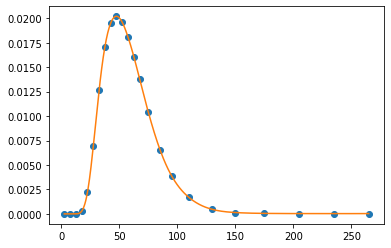

In [7]:
min_inter, max_inter = min(selected["midpoint"]), max(selected["midpoint"])
xnew = np.linspace(min_inter, max_inter, num=400, endpoint=True)
plt.plot(selected["midpoint"], selected["norm_tissue_integral"], 'o', xnew, f(xnew), '-')
plt.savefig("spline.jpg")
plt.show()

In [8]:
def generate_samples(size, upper, lower):
    samples = []
    while len(samples) < size:
        p = np.random.uniform(0, 1)
        x = np.random.uniform(upper, lower)
        if f(x) > p:
            samples.append(x)
    return samples

In [9]:
samples = generate_samples(2000, min_inter, max_inter)

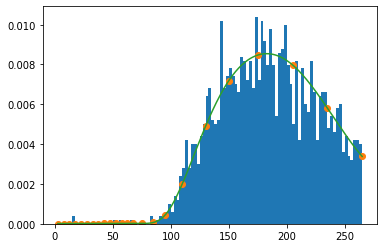

In [10]:
plt.hist(samples, density=True, bins=100)
plt.plot(selected["midpoint"], selected["norm_tissue_integral"], 'o', xnew, f(xnew), '-')

In [11]:
params = exponnorm.fit(samples)

/home/mikael/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1415: RuntimeWarning: divide by zero encountered in log
  return exparg + np.log(0.5 * invK * sc.erfc(-(x - invK) / np.sqrt(2)))


In [12]:
params

(0.02974346089674828, 182.88509772087235, 41.412122551655294)

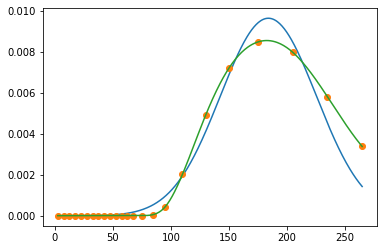

In [13]:
s = exponnorm.rvs(params[0], params[1], params[2], size=900)
plt.plot(xnew, exponnorm.pdf(xnew, params[0], params[1], params[2]))
plt.plot(selected["midpoint"], selected["norm_tissue_integral"], 'o', xnew, f(xnew), '-')

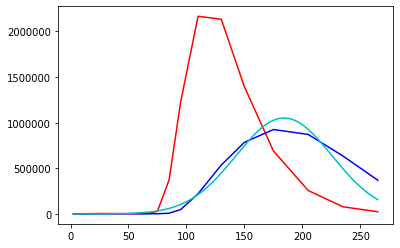

In [14]:
plt.plot(selected["midpoint"], selected["input"], color="r")
plt.plot(selected["midpoint"], selected["tissue"], color="b")
plt.plot(xnew, integral * exponnorm.pdf(xnew, params[0], params[1], params[2]), color="c")
plt.savefig("testi.jpg")

In [ ]:
for s, q in zip(sizes, qclear):
    data = selected = df[(df["qclear"] == q) & (df["size"] == s)]
    max_input = np.max(data["input"])
    idx = np.argmax(data["input"] > (max_input / 4))
    data["a"] = data["midpoint"][idx]
    print(s, q, data)

Skaalaa tn-jakaumaksi
Tee kde ja tee siitä otoksia
Sovita tähän malli
Skaalaa takaisin

Update:
Do this with minimize and define own curve to fit. This way you can fi

In [51]:
selected["tissue"] /= max(selected["tissue"])

/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
def exponential_gaussian(x, lambda_, mu, sigma, h):
    return h * np.exp(0.5*lambda_*(2*mu+lambda_*sigma*sigma-2*x))*scipy.special.erfc((mu+lambda_*sigma*sigma-x)/(np.sqrt(2)*sigma))

In [53]:
def exponential_gauss(x, mu, sigma, lambda_, scale):
    K = 1 / (sigma * lambda_)
    total = scipy.stats.exponnorm.pdf(x, K=K, loc=mu, scale=scale)
    return total

In [90]:
def EMG(x, h, mu, sigma, lambda_):
    tau = 1 / lambda_
    if tau <= 1e-3:
        tau = 1e-6
    if sigma <= 1e-3:
        sigma = 1e-3
    def formula(x, h, mu, sigma, tau):
        z = (1 / np.sqrt(2)) * ((sigma / tau) - ((x - mu) / sigma))
        val = h * np.exp(-0.5 * ((x - mu) / sigma)**2) * (sigma/tau) *  np.sqrt(np.pi / 2) * scipy.special.erfcx(z)
        return val
        print(here)
        ### FIX THIS 
        if z < 6.71*10**7:
            #val = ((h * sigma) / tau) * np.sqrt(np.pi / 2) * np.exp(0.5 * (sigma / tau)**2 - ((x - mu) / tau)) * scipy.special.erfcx(z)
            val = h * np.exp(-0.5 * ((x - mu) / sigma)**2) * (sigma/tau) *  np.sqrt(np.pi / 2) * scipy.special.erfcx(z)
            return val
        else:
            #print("here")
            #DONT USE
            val = h * np.exp(-0.5 * ((x - mu) / sigma)**2) / (1 + (((x  -mu) * tau) / sigma**2))
            return val
    y = np.asarray([formula(x_, h, mu, sigma, tau) for x_ in x])
    return y                                              

In [ ]:
xnew = np.linspace(-4, 10, num=100, endpoint=True)
# EMG == expg jos EMG h on vähän suurempi
y_EMG = EMG(xnew, h=2.15, mu=0, sigma=3, lambda_=0.25)
#y_expg = exponential_gaussian(xnew, lambda_=0.25, mu=0, sigma=3, scale=2)
y_scipy = exponnorm.pdf(xnew, 0.5, 0.5, 1.25)
y_sums = exponential_gauss(xnew, mu=3, sigma=1, lambda_=20, scale=3)
#plt.plot(xnew, y_EMG)
#plt.plot(xnew, y_expg)
plt.plot(xnew, y_sums)
#plt.plot(xnew, y_scipy)

In [31]:
popt, pcov = curve_fit(EMG, xdata=selected["midpoint"], ydata=selected["tissue"], p0=[180, 30, 40, 1])
popt

/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


array([ 7.97586346e+05,  5.24104632e+01,  1.79791439e+01, -4.34020157e+03])

In [ ]:
xnew = np.linspace(min(selected["midpoint"])-100, max(selected["midpoint"]), num=100, endpoint=True)

y_EMG = EMG(xnew, h=800000, mu=0, sigma=15, lambda_=0.01)
#y_other = exponential_gaussian(xnew, h=5, mu=50, sigma=15, lambda_=0.25)
y_log_norm = scipy.stats.lognorm.pdf(xnew, loc=50, scale=20, s=0.01)

plt.plot(selected["midpoint"], selected["tissue"], marker="o")
plt.plot(xnew, y_EMG, color="r")
#plt.plot(xnew, y_log_norm)
#plt.plot(xnew, y_other)

In [ ]:
plt.plot(selected["midpoint"], selected["tissue"])
x_points = np.arange(min(selected["midpoint"]), max(selected["midpoint"]))
y_EMG = EMG(x_points, 910000, 180, 40, 1)
plt.plot(x_points, y_EMG)


In [36]:
selected["midpoint"][np.argmax(selected["tissue"])]

47.5

In [95]:
def EMG_loss(x):
    # x[0] = h, x[1] = mu, x[2]= sigma, x[3] = lambda_, x[4]= x_axis_scale
    x_times = selected["tissue"]
    tissues = selected["midpoint"]
    x_times = x_times - x[4]
    EMG_val = EMG(x_times, x[0], x[1], x[2], x[3])
    return np.sum((tissues - EMG_val) ** 2)

In [96]:
EMG_loss([max_tissue, 4, 30, 4, highest_x_val])

/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


107888227620.54897

In [97]:
max_tissue = max(selected["tissue"])
highest_x_val = selected["midpoint"][np.argmax(selected["tissue"])]
scipy.optimize.minimize(EMG_loss, x0=[max_tissue, 4, 30, 4, highest_x_val])

/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


      fun: 0.0
 hess_inv: array([[ 1.00000000e+00,  1.04037606e-05, -1.33288076e-05,
        -6.11016342e-07,  1.04037606e-05],
       [ 1.04037606e-05,  7.01212473e-01,  3.52883874e-01,
         1.71634396e-02, -2.98787527e-01],
       [-1.33288076e-05,  3.52883874e-01,  6.21377510e-01,
        -1.97805156e-02,  3.52883874e-01],
       [-6.11016342e-07,  1.71634396e-02, -1.97805156e-02,
         9.99020374e-01,  1.71634396e-02],
       [ 1.04037606e-05, -2.98787527e-01,  3.52883874e-01,
         1.71634396e-02,  7.01212473e-01]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([ 7.86464122e+05, -2.38936263e+01, -2.06589278e+01,  4.52766299e+00,
        1.96063737e+01])